# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.x

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
# Запустите эту ячейку если работаете в Colab
!git clone https://github.com/TheAceHome/ML.git
%cd ML/data
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../Assignment3

Cloning into 'ML'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 241 (delta 99), reused 190 (delta 71), pack-reused 0
Receiving objects: 100% (241/241), 1.14 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/ML/data
--2021-03-08 13:47:07--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  55.8MB/s    in 3.4s    

2021-03-08 13:47:10 (50.5 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-03-08 13:47:10--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [17]:
# First, lets load the dataset
data_train = dset.SVHN('../data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('../data/', split='test',
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [5]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [6]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [8]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    correct_samples = 0
    total_samples = 0

    for x, y in loader:
        prediction = model(x)

        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.712047, Train accuracy: 0.472614, Val accuracy: 0.572589
Average loss: 1.433458, Train accuracy: 0.597362, Val accuracy: 0.617569
Average loss: 1.370943, Train accuracy: 0.625892, Val accuracy: 0.635725


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [9]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3 * 32 * 32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.182439, Train accuracy: 0.193496, Val accuracy: 0.222237
Average loss: 2.047044, Train accuracy: 0.248336, Val accuracy: 0.304348
Average loss: 1.860182, Train accuracy: 0.355561, Val accuracy: 0.402703
Average loss: 1.718658, Train accuracy: 0.416203, Val accuracy: 0.420654
Average loss: 1.684032, Train accuracy: 0.432038, Val accuracy: 0.431711


Добавьте слой с Batch Normalization

In [10]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3 * 32 * 32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.072552, Train accuracy: 0.300822, Val accuracy: 0.401133
Average loss: 1.799848, Train accuracy: 0.439801, Val accuracy: 0.495461
Average loss: 1.656933, Train accuracy: 0.510613, Val accuracy: 0.552181
Average loss: 1.568358, Train accuracy: 0.555097, Val accuracy: 0.585080
Average loss: 1.506051, Train accuracy: 0.586237, Val accuracy: 0.611426


Добавьте уменьшение скорости обучения по ходу тренировки.

In [13]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3 * 32 * 32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.079443, Train accuracy: 0.309644, Val accuracy: 0.448570
Average loss: 1.778210, Train accuracy: 0.476538, Val accuracy: 0.535595
Average loss: 1.633572, Train accuracy: 0.543664, Val accuracy: 0.591700
Average loss: 1.544230, Train accuracy: 0.583916, Val accuracy: 0.613883
Average loss: 1.482324, Train accuracy: 0.611712, Val accuracy: 0.637021


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [14]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, sampler=sampler)
    
    predictions, ground_truth = [], []
    for x, y in loader:
        _, indices = torch.max(model(x), 1)
        predictions.append(indices)
        ground_truth.append(y)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

![image.png](attachment:image.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

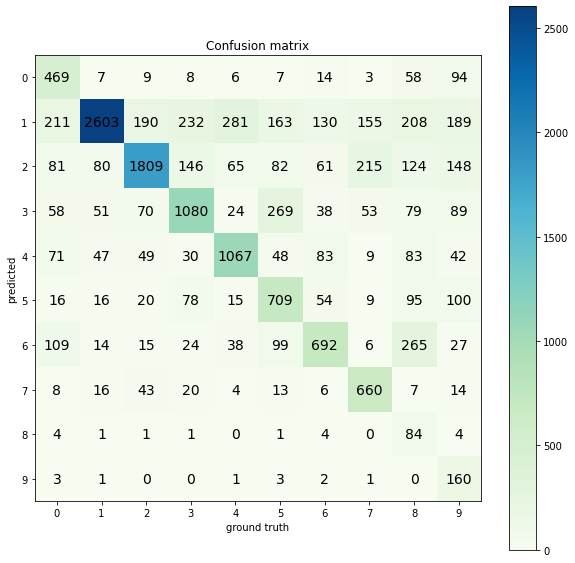

In [15]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    for pred, truth in zip(predictions, ground_truth):
        confusion_matrix[pred][truth] += 1

    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [21]:
data_train_images = dset.SVHN('./data/', split='train',download=True)

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    indices = val_indices[(predictions == predicted_class) & (groud_truth == gt_class)]
    visualize_images(indices, data, 'Predicted as the wrong class')

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

Using downloaded and verified file: ./data/train_32x32.mat


<Figure size 720x108 with 0 Axes>

<Figure size 720x108 with 0 Axes>

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [23]:
import itertools

In [27]:
learning_rates = [1e-3]
ns_neurons = [100]
weight_decays = [1e-3]
optimizers = [optim.SGD]
n_epochs = 25

In [28]:
best_classifier = None
best_optimizer = None
best_val_accuracy = None

for lr, n_neurons, weight_decay, nn_optimizer in itertools.product(learning_rates, 
                                                                ns_neurons, 
                                                                weight_decays,
                                                                optimizers):
    print(f'learning_rate={lr}, n_neurons={n_neurons}, weight_decay={weight_decay}, optimizer={nn_optimizer.__name__}')

    nn_models = [nn.Sequential(Flattener(),
                               nn.Linear(3 * 32 * 32, n_neurons),
                               nn.BatchNorm1d(n_neurons),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_neurons, 10),
                              ),
                 nn.Sequential(Flattener(),
                               nn.Linear(3 * 32 * 32, n_neurons),
                               nn.BatchNorm1d(n_neurons),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_neurons, n_neurons),
                               nn.BatchNorm1d(n_neurons),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_neurons, 10),
                              )
                ]

    for nn_model in nn_models:
        optimizer = nn_optimizer(nn_model.parameters(), lr=lr, weight_decay=weight_decay)
        _, _, val_hist = train_model(nn_model, train_loader, val_loader, loss, optimizer, n_epochs)
        accuracy = val_hist[-1]
        
        if not best_val_accuracy or accuracy > best_val_accuracy:
            best_classifier = nn_model
            best_optimizer = optimizer
            best_val_accuracy = accuracy

learning_rate=0.001, n_neurons=100, weight_decay=0.001, optimizer=SGD
Average loss: 2.092902, Train accuracy: 0.282565, Val accuracy: 0.388984
Average loss: 1.828694, Train accuracy: 0.437242, Val accuracy: 0.504471
Average loss: 1.673325, Train accuracy: 0.524230, Val accuracy: 0.583100
Average loss: 1.564290, Train accuracy: 0.583166, Val accuracy: 0.626715
Average loss: 1.478819, Train accuracy: 0.618793, Val accuracy: 0.644529
Average loss: 1.412878, Train accuracy: 0.642921, Val accuracy: 0.658044
Average loss: 1.355366, Train accuracy: 0.660103, Val accuracy: 0.688690
Average loss: 1.305861, Train accuracy: 0.673225, Val accuracy: 0.703228
Average loss: 1.263964, Train accuracy: 0.685800, Val accuracy: 0.708484
Average loss: 1.226411, Train accuracy: 0.694400, Val accuracy: 0.723841
Average loss: 1.192280, Train accuracy: 0.702488, Val accuracy: 0.721452
Average loss: 1.163417, Train accuracy: 0.707760, Val accuracy: 0.733329
Average loss: 1.136119, Train accuracy: 0.713920, Val 

In [29]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7921
